In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2, random, json, itertools

from IPython.display import SVG
from tensorflow import keras
# from tensorflow.keras.utils import *
from keras.utils.vis_utils import model_to_dot
import pydot
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, 
                                    MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import files

In [ ]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], label="Training Loss")
    ax[0].plot(history.history['val_loss'], label="Validation Loss")
    ax[1].plot(history.history['accuracy'], label="Training Accuracy")
    ax[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass


def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.0
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = "center",
                color = "white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(None);
    pass

In [ ]:
dataset_path = "/content/drive/MyDrive/Images/archive/images"

with open("/content/drive/MyDrive/Images/archive/label_map.json","r") as file:
    class_name_binarized = json.load(file)

In [ ]:
num_classes = len(class_name_binarized)
class_names = list(class_name_binarized.keys())
print(class_name_binarized)

{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'intersection': 10, 'mediumresidential': 11, 'mobilehomepark': 12, 'overpass': 13, 'parkinglot': 14, 'river': 15, 'runway': 16, 'sparseresidential': 17, 'storagetanks': 18, 'tenniscourt': 19, 'harbor': 20}


In [ ]:
def load_data(csv_file):
    images, labels = [], []
    
    data = pd.read_csv(csv_file,index_col="Unnamed: 0")
    
    for i in tqdm(range(data.shape[0])):
        
        img_name = data.loc[i,'Filename']
        img = load_img(os.path.join(dataset_path,img_name),target_size=(224,224))
        img = img_to_array(img)
        
        img = preprocess_input(img)
        label = data.loc[i,'Label']
        
        images.append(img)
        labels.append(label)
        pass
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels
    pass

In [ ]:
train_images, train_labels = load_data("/content/drive/MyDrive/Images/archive/train.csv")
val_images, val_labels = load_data("/content/drive/MyDrive/Images/archive/validation.csv")
train_images.shape, train_labels.shape, val_images.shape, val_labels.shape

100%|██████████| 2100/2100 [24:54<00:00,  1.41it/s]


((7350, 224, 224, 3), (7350,), (2100, 224, 224, 3), (2100,))

In [ ]:
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
train_labels.shape, val_labels.shape

((7350, 21), (2100, 21))

In [ ]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'conv_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + '_branch'
    ac_base_name = 'ac_' + str(stage) + block + '_branch'
    
    F1 = filters
    
    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same', name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation("relu", name=ac_base_name+'2a')(X)
    
    return X
    pass

In [ ]:
def conv_model(input_shape, classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((5,5),name="zero_padding_1")(X_input)
    
    X = Conv2D(16,(3,3), strides=(2,2), name='conv1', padding="same")(X)
    X = BatchNormalization(name="bn_conv1")(X)
    
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2), name="max_pooling_2")(X)
    X = Dropout(0.25, name="dropout_2")(X)
    
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2), name="max_pooling_3")(X)
    X = Dropout(0.25, name="dropout_3")(X)
    
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2), name="max_pooling_4")(X)
    X = Dropout(0.25, name="dropout_4")(X)
    
    X = Flatten(name="flatten_1")(X)
    X = Dense(64,name="dense_1")(X)
    X = Activation("relu",name="dense_relu_1")(X)
    
    X = Dense(128,name="dense_2")(X)
    X = Activation("relu", name="dense_relu_2")(X)
    
    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)
    
    model = Model(inputs=X_input, outputs=X, name="Basic_Conv_model")
    
    return model
    pass

In [ ]:
model = conv_model(input_shape=(224,224,3),classes=num_classes)

plot_model(model,to_file='basic_conv_model.png',show_shapes=True,show_layer_names=True)
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

In [ ]:
opt = Adam(lr=1e-3)
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

In [ ]:
epochs = 50
batch_size = 10

Epoch 1/50
735/735 [==============================] - ETA: 0s - loss: 2.6422 - accuracy: 0.1727
Epoch 1: val_accuracy improved from -inf to 0.27048, saving model to model_weights.h5
735/735 [==============================] - 295s 397ms/step - loss: 2.6422 - accuracy: 0.1727 - val_loss: 2.3107 - val_accuracy: 0.2705
Epoch 2/50
735/735 [==============================] - ETA: 0s - loss: 2.1003 - accuracy: 0.3224
Epoch 2: val_accuracy improved from 0.27048 to 0.33857, saving model to model_weights.h5
735/735 [==============================] - 291s 395ms/step - loss: 2.1003 - accuracy: 0.3224 - val_loss: 1.9189 - val_accuracy: 0.3386
Epoch 3/50
735/735 [==============================] - ETA: 0s - loss: 1.8802 - accuracy: 0.3656
Epoch 3: val_accuracy improved from 0.33857 to 0.40524, saving model to model_weights.h5
735/735 [==============================] - 291s 396ms/step - loss: 1.8802 - accuracy: 0.3656 - val_loss: 1.7669 - val_accuracy: 0.4052
Epoch 4/50
735/735 [=======================

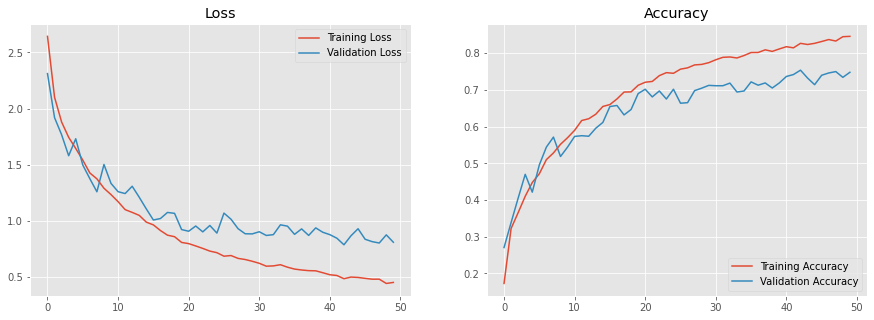

In [ ]:
history = model.fit(train_images, train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images, val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs])

show_final_history(history)

In [ ]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred, axis=1)
val_pred.shape

(2100,)

<Figure size 432x288 with 0 Axes>

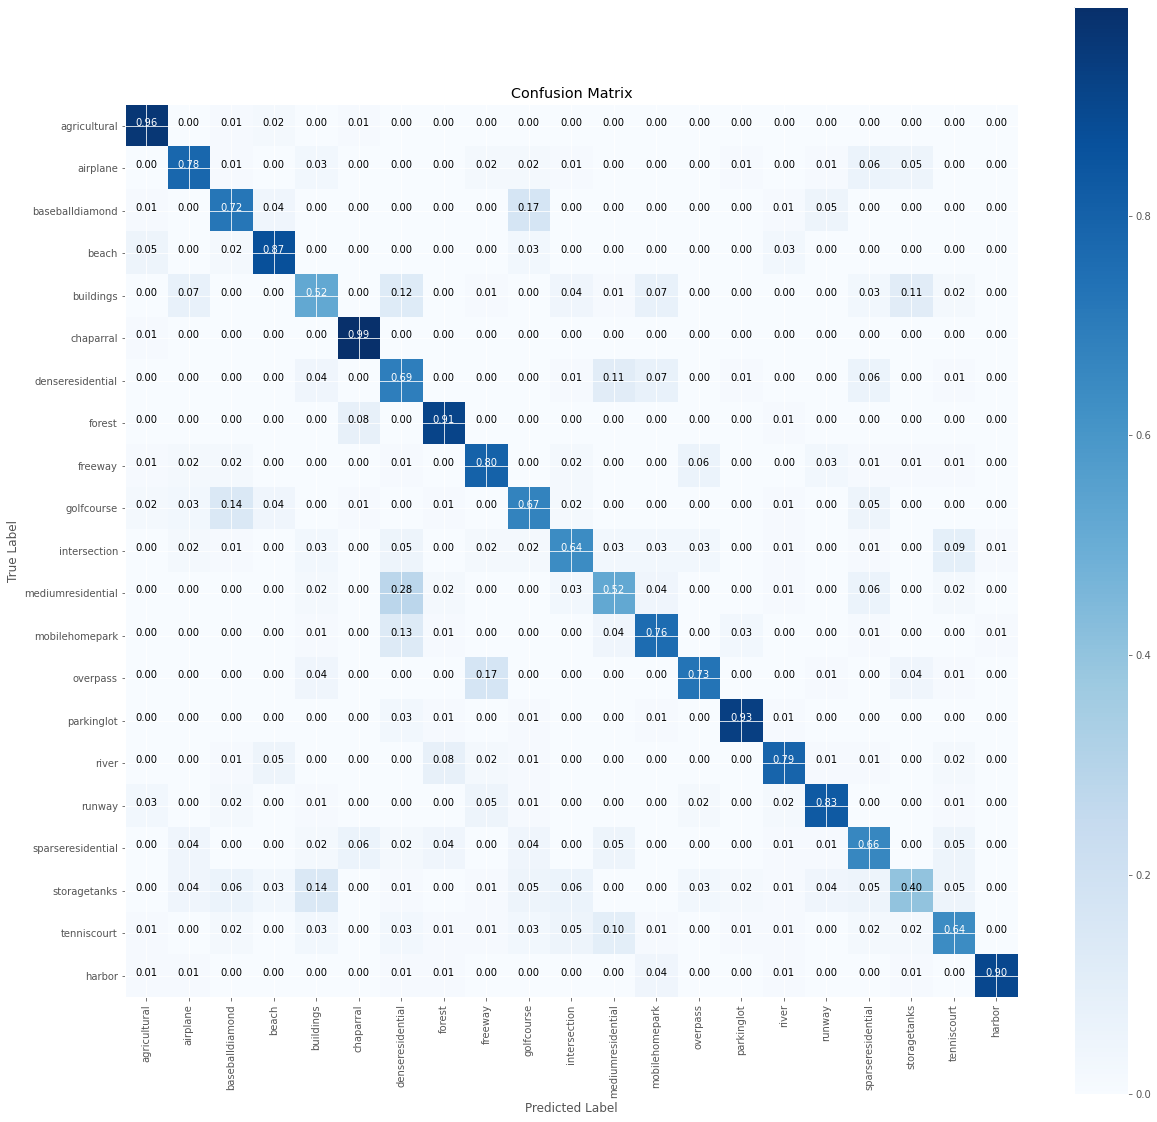

In [ ]:
val_actual = np.argmax(val_labels, axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.grid(None)
plt.show();

In [ ]:
train_dir = "/content/drive/MyDrive/Images/archive/images_train_test_val/train"
val_dir = "/content/drive/MyDrive/Images/archive/images_train_test_val/validation"

batchSize = 10

IGD = ImageDataGenerator(rescale=1./255.)

train_generator = IGD.flow_from_directory(train_dir,
                                         target_size=(224,224),
                                         color_mode='rgb',
                                         batch_size=batchSize,
                                         class_mode='categorical',
                                         shuffle=True,
                                         seed=42)

val_generator = IGD.flow_from_directory(val_dir,
                                        target_size=(224,224),
                                        color_mode='rgb',
                                        batch_size=batchSize,
                                        class_mode='categorical',
                                        shuffle=True,
                                        seed=42)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


In [ ]:
model_1 = MobileNet(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layer in model_1.layers:
    layer.trainable = False

model_1.summary()

In [ ]:
headModel = model_1.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)

model_2 = Model(inputs=model_1.input, outputs=headModel)

model_2.summary()

In [ ]:
opt_2 = Adam(lr=1e-3)
model_2.compile(loss="categorical_crossentropy",optimizer=opt_2,metrics=['accuracy'])

In [ ]:
plot_model(model_2,to_file='MobileNet_transfer_model.png',show_shapes=True,show_layer_names=True)
SVG(model_to_dot(model_2).create(prog='dot',format='svg'))

In [ ]:
MobileNet_checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
MobileNet_logs = TensorBoard("MobileNet-transfer-logs")

In [ ]:
epochs = 30
batchSize = 10

history = model_2.fit(train_images, train_labels,
                      steps_per_epoch=len(train_images)//batchSize,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(val_images,val_labels),
                      validation_steps=len(val_images)//batchSize,
                      callbacks=[MobileNet_checkpoint, MobileNet_logs])

Epoch 1/30
735/735 [==============================] - ETA: 0s - loss: 0.9090 - accuracy: 0.7222
Epoch 1: val_accuracy improved from -inf to 0.91524, saving model to model_weights.h5
735/735 [==============================] - 333s 450ms/step - loss: 0.9090 - accuracy: 0.7222 - val_loss: 0.2642 - val_accuracy: 0.9152
Epoch 2/30
735/735 [==============================] - ETA: 0s - loss: 0.3273 - accuracy: 0.8905
Epoch 2: val_accuracy improved from 0.91524 to 0.94333, saving model to model_weights.h5
735/735 [==============================] - 332s 452ms/step - loss: 0.3273 - accuracy: 0.8905 - val_loss: 0.1667 - val_accuracy: 0.9433
Epoch 3/30
735/735 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9197
Epoch 3: val_accuracy improved from 0.94333 to 0.95238, saving model to model_weights.h5
735/735 [==============================] - 332s 452ms/step - loss: 0.2472 - accuracy: 0.9197 - val_loss: 0.1358 - val_accuracy: 0.9524
Epoch 4/30
735/735 [=======================

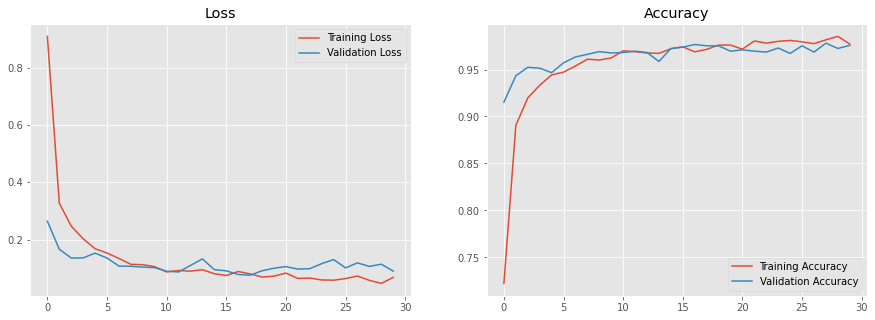

In [ ]:
show_final_history(history)

In [ ]:
val_pred = model_2.predict(val_images)
val_pred = np.argmax(val_pred, axis=1)
val_pred.shape

(2100,)

<Figure size 432x288 with 0 Axes>

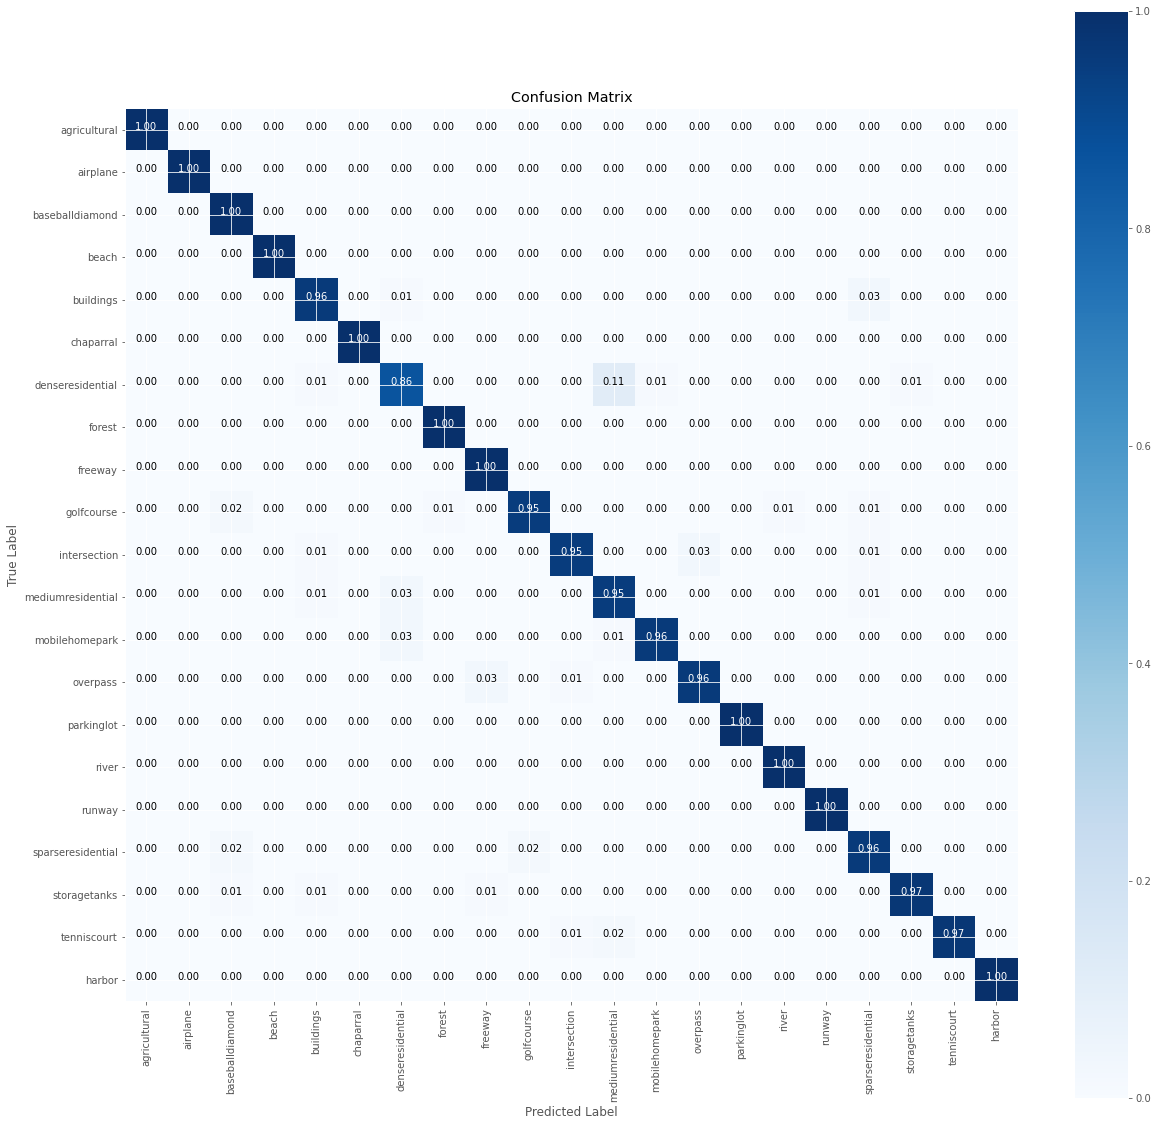

In [ ]:
val_actual = np.argmax(val_labels, axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.grid(None)
plt.show();

In [ ]:
model_2.save("MobileNet_transfer_model.h5")